# Umap from Metadata

This notebook loads a csv and builds a Umap visualisation around one metadata column.

To be able to re-use this script we use open source items from [Wikidata](https://query.wikidata.org/#%23defaultView%3AImageGrid%0ASELECT%20%2a%0AWHERE%0A%7B%0A%20%20%3Fitem%20wdt%3AP31%20wd%3AQ3305213%20.%0A%20%20%3Fitem%20wdt%3AP170%20wd%3AQ5598%20.%0A%20%20%3Fitem%20wdt%3AP18%20%3Fpic%20.%0A%20%20%3Fitem%20wdt%3AP1476%20%3Ftitle%20.%0A%0A%7D). 
<br>We query the sparql endpoint to retrieve all paintings by Rembrandt and their title. <br> 


Then we save a csv file and we import it.

### Import Variables

In [5]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

### Read Data

In [6]:
url = "../assets/query.csv"
data = pd.read_csv(url)

Define the csv column to build the umap from.url = "assets/data.csv"
data = pd.read_csv(url)

In [7]:
data.head()

,item,pic,title
0,http://www.wikidata.org/entity/Q21485733,http://commons.wikimedia.org/wiki/Special:File...,Bildnis eines alten Mannes mit Bart und Barett
1,http://www.wikidata.org/entity/Q21486188,http://commons.wikimedia.org/wiki/Special:File...,Bildnisstudie eines jungen Juden
2,http://www.wikidata.org/entity/Q21487137,http://commons.wikimedia.org/wiki/Special:File...,Christus verschijnt voor Maria Magdalena (Noli...
3,http://www.wikidata.org/entity/Q21491919,http://commons.wikimedia.org/wiki/Special:File...,"Titus van Rijn, der Sohn des Künstlers, lesend"
4,http://www.wikidata.org/entity/Q21491919,http://commons.wikimedia.org/wiki/Special:File...,"Titus van Rijn, der Sohn des Künstlers, lesend"


In [8]:
metadata = "title"

In [9]:
selection = data[metadata]

In [10]:
selection

0         Bildnis eines alten Mannes mit Bart und Barett
1                       Bildnisstudie eines jungen Juden
2      Christus verschijnt voor Maria Magdalena (Noli...
3         Titus van Rijn, der Sohn des Künstlers, lesend
4         Titus van Rijn, der Sohn des Künstlers, lesend
                             ...                        
439                                          Autoportret
440                           Self-portrait of Rembrandt
441                               Autoportret Rembrandta
442        Christ Healing The Sick by Rembrandt Van Rijn
443                   Cottage Farm by Rembrandt Van Rijn
Name: title, Length: 444, dtype: object

## Training

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()

components = cv.fit_transform(selection)
components.shape

(444, 731)

In [12]:
import umap.umap_ as umap

reducer = umap.UMAP(
        n_neighbors=7,
        min_dist=.4 
)

pipe = Pipeline([('scaling', StandardScaler()), ('umap', reducer)])
embedding = pipe.fit_transform(components.toarray())

umap_positions = pd.DataFrame(embedding, columns=["x", "y"])

data_umap = pd.concat([data, umap_positions], axis = 1)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
x_domain = [data_umap["x"].min(), data_umap["x"].max() ]
y_domain = [data_umap["y"].min(), data_umap["y"].max() ]

### Display the cluster

In [14]:
alt.Chart(data_umap).mark_circle().encode(
    alt.X('x', scale=alt.Scale(domain=x_domain), axis=alt.Axis(labels=False)),
    alt.Y('y', scale=alt.Scale(domain=y_domain), axis=alt.Axis(labels=False)),
    tooltip=metadata
).properties(width=400, height=400)

alt.Chart(...)

In [15]:
tx, ty = data_umap["x"].dropna(), data_umap["y"].dropna()
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Add images

See: `Save images from Wikidata.ipynb` to create a folder containing images from Wikidata.

Specify the path where to load the images

In [24]:
path = '../assets/wikidata_crop/'

In [25]:
ids = data['item'].tolist()

### Plots the clusters

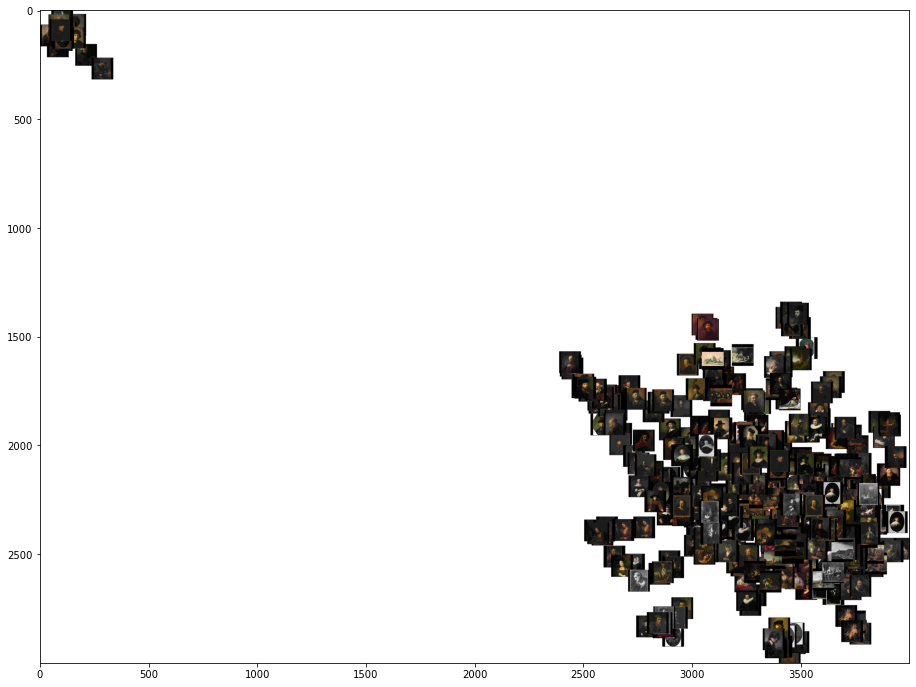

In [26]:
import matplotlib.pyplot
from PIL import Image
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))

for imgId, x, y in zip(ids, tx, ty):
    img = path + str(imgId.replace("http://www.wikidata.org/entity/","")) + ".jpg"
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

        
matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

###  Export the generated csv

In [27]:
import os  
os.makedirs('../data/', exist_ok=True)  
data_umap.to_csv('../data/' + metadata + '_out.csv')  